In [1]:
import numpy as np
import nolds
from matplotlib import pyplot as plt
from numpy import linalg as la
import os
from scipy import stats as st
from scipy import spatial as sp
from scipy import sparse
from sklearn import linear_model
from scipy import linalg as sla

import lyapynov as le

import pandas as pd
import networkx as nx

import SystemsSolved as s
import Methods as m

import Sparse_Reservoir_Computing as rc

import RecurrencePlotsCode as rp

import multiprocess as mp

import Parallel_Grid_Search as pgs
import openpyxl as op 

In [10]:
%%time
mu_pts = np.linspace(0.2, 0.3, 41); nu = 0.02
mu_pts[5]

CPU times: total: 0 ns
Wall time: 1.4 ms


0.21250000000000002

In [6]:
sigma_pts = np.linspace(0.01, 0.95, 10); rho_pts = np.linspace(0.01, 0.95, 10); gamma_pts = [1]
params = pgs.parameters_reshape_gridsearch(sigma_pts, rho_pts, gamma_pts)
file = "C:\\Users\\jackr\\JackRoss_FYP_2024\\Python_Files\\OutputData\\ReservoirParameters.xlsx"

In [ ]:
%%time
k = 1
for i in range(6, len(mu_pts)):
    Ry = s.yCoupledRossler(a = 0.2, b = 0.2, c = 5.7, 
                           nu1 = nu, mu1 = mu_pts[i], nu2 = nu, mu2 = mu_pts[i])
    Ry_ts = Ry.solve(t0 = 0, tFinal = 1000, x0_1 = [-1.5, 1.5, 20], x0_2 = [-1, -1, 10], dt = 0.01)

    #Splits ts and removes transient time 
    A0 = Ry_ts[0:3, :]; B0 = Ry_ts[3:6, :] 
    A = pgs.gridSearchRC_parallell(params, A0, processes = 16, t_evolve = 1000, t_listen = 700, t_train = 500, Nodes = 100, dt = 0.01)
    B = pgs.gridSearchRC_parallell(params, B0, processes = 16, t_evolve = 1000, t_listen = 700, t_train = 500, Nodes = 100, dt = 0.01)
    output = [A + B + [mu_pts[i].tolist()]]

   
    wb = op.load_workbook(file); ws = wb.active
    for row in output:
        ws.append(row)
    wb.save(file)
    print(k)
    k = k+1
    

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\jackr\\JackRoss_FYP_2024\\Python_Files\\OutputData\\ReservoirParameters.xlsx'

In [8]:
output

[[0.741111111111111,
  0.3233333333333333,
  1,
  0.8455555555555555,
  0.6366666666666666,
  1,
  0.21250000000000002]]

In [9]:
wb = op.load_workbook(file); ws = wb.active
for row in output:
    ws.append(row)
wb.save(file)


In [ ]:
k = 1
for i in range(1, len(mu_pts)):
    Ry = s.yCoupledRossler(a = 0.2, b = 0.2, c = 5.7, 
                           nu1 = nu, mu1 = mu_pts[i], nu2 = nu, mu2 = mu_pts[i])
    Ry_ts = Ry.solve(t0 = 0, tFinal = 1000, x0_1 = [-1.5, 1.5, 20], x0_2 = [-1, -1, 10], dt = 0.01)

    #Splits ts and removes transient time 
    A0 = Ry_ts[0:3, :]; B0 = Ry_ts[3:6, :] 
    A = pgs.gridSearchRC_parallell(params, A0, processes = 6, t_evolve = 1000, t_listen = 700, t_train = 500, Nodes = 100, dt = 0.01)
    B = pgs.gridSearchRC_parallell(params, B0, processes = 6, t_evolve = 1000, t_listen = 700, t_train = 500, Nodes = 100, dt = 0.01)
    output = [A + B + mu_pts[i]]

   
    wb = op.load_workbook(file); ws = wb.active
    for row in output:
        ws.append(row)
    wb.save(file)
    print(k)
    k = k+1
    

NameError: name 'params' is not defined

In [7]:
#Setting up Reservoir B0

#Parameters
sigma = 0.741111111111111 #Drive
rho =  0.5322222222222222  #Spectral Radius

r2 = rc.Reservoir(Nodes = 100, InDim=3, seed=12)
r2.Weighted_Erdos_R(SpecRadius=rho, p=0.04)
r2.set_rdot(sigma = sigma, gamma = 1)
r2.Set_W_in_Matrix() #Error from normalising specral radius

rc2 = rc.RC(SparseReservoir=r2, U=U, dt = 0.01)

rc2.Listening(time=700)
rc2.Training(t0 = 500, tEnd = 700)
rc2.Predicting(t0 = 700, tFinal = 1700)

c:\Users\jackr\anaconda3\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited at iteration 20 with accuracies 
[1.5179179e-05]
not reaching the requested tolerance 1.4901161193847656e-06.
Use iteration 21 instead with accuracy 
1.5179179046911312e-05.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
c:\Users\jackr\anaconda3\Lib\site-packages\scipy\sparse\linalg\_eigen\_svds.py:487: UserWarning: Exited postprocessing with accuracies 
[1.5179179e-05]
not reaching the requested tolerance 1.4901161193847656e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


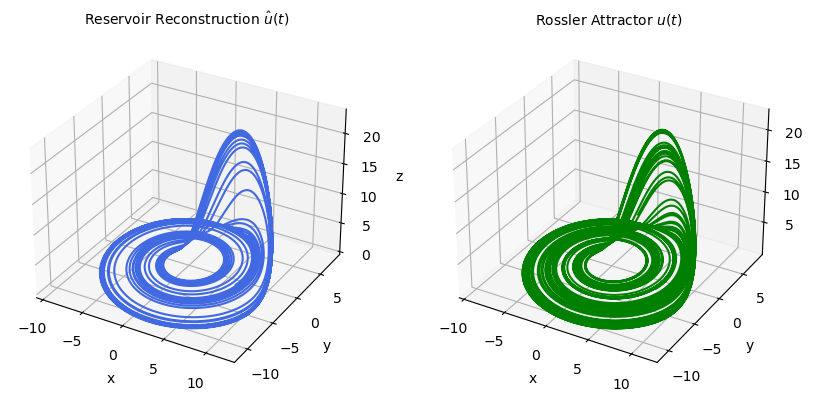

In [21]:
p2 = m.plot3D(cols=2, rows=2, figsize=(10, 15))

p2.plot3D(rc2.uPrediction[:, 10:30000], plotNum=1, title = "Reservoir Reconstruction " + r'$ \hat u(t)$', tick_label_color='k') #+r'$ \sigma = $'+str(sigma)+" "+r'$ \rho = $'+str(rho) )

p2.plot3D(U[:, 70000:100000], plotNum=2, title = "Rossler Attractor " + r'$ u(t)$', tick_label_color='k' )

In [11]:
RCstats = pgs.RC_Stats_test(U = U)

In [16]:
print(RCstats.autocorrelation(rc2.uPrediction))
print(RCstats.MSE(rc2.uPrediction))
print(RCstats.mean(rc2.uPrediction))
print(RCstats.var(rc2.uPrediction))


0.9816678047255157
180.84584005024132
0.000402031456032452
0.45954515467850854


In [35]:
a = np.correlate(rc2.uPrediction[0, :], rc2.uPrediction[0, :], mode='full')
b = np.correlate(U[0, :], U[0, :], mode='full')
st.pearsonr(a, b).statistic


0.9816678047255157

In [29]:
a.shape

(199999,)

In [30]:
time = np.linspace(-1000, 1000, a.shape[0])

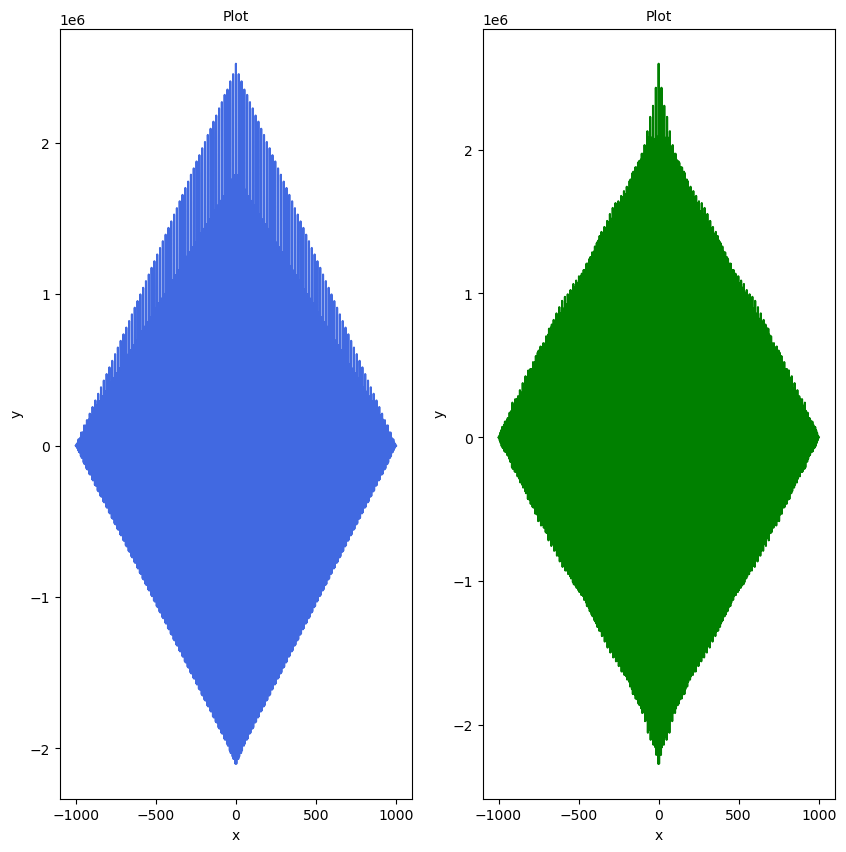

In [32]:
p = m.plot3D(cols=2, rows =1, figsize=(10, 10))
p.plot2D(time, a, plotNum=1)
p.plot2D(time, b, plotNum=2)